In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#

In [3]:
#import
train_data = pd.read_csv('C:/Users/adnan/Downloads/priorordersmerged2.csv')
train_data = train_data.dropna()# Replace with the path to your training table
test_data = pd.read_csv('C:/Users/adnan/Downloads/trainorder.csv')    
test_data = test_data.dropna()

In [4]:
# Products per order
product_count = train_data['order_id'].value_counts().reset_index()
product_count.columns = ['order_id', 'product_count']

product_count2 = test_data['order_id'].value_counts().reset_index()
product_count2.columns = ['order_id', 'product_count']

In [5]:
# Merge the product count 
train_data = train_data.merge(product_count, on='order_id')
test_data = test_data.merge(product_count2, on='order_id')

In [6]:
# Indicator columns for each product department
department_columns = pd.get_dummies(train_data['department_id']).astype(bool)
department_columns2 = pd.get_dummies(test_data['department_id']).astype(bool)


In [7]:
# Merge the department indicator columns 
train_data = pd.concat([train_data, department_columns], axis=1)
train_data.drop('department_id', axis=1, inplace=True)


#repeat for test
test_data = pd.concat([test_data, department_columns2], axis=1)
test_data.drop('department_id', axis=1, inplace=True)

In [8]:

train_data = train_data.groupby('order_id').agg({
    'product_count': 'first',                      # Number of products in the order
    'order_dow': 'first',                          # Day of the week of the order 
    'days_since_prior_order': 'first',             # Days since the prior order 
    'order_hour_of_day': 'first',                  # Hour of the day of the order 
   
    **{column: 'max' for column in department_columns.columns}
}).reset_index()


test_data = test_data.groupby('order_id').agg({
    'product_count': 'first',                     
    'order_dow': 'first',                          
    'days_since_prior_order': 'first',             
    'order_hour_of_day': 'first',                  
    
    **{column: 'max' for column in department_columns.columns}
}).reset_index()


In [9]:
# Rename 
department_mapping = {
    column: f'department_{column}_indicator' for column in department_columns.columns
}
train_data.rename(columns=department_mapping, inplace=True)

#print(train_data)

#repeat
department_mapping2 = {
    column: f'department_{column}_indicator' for column in department_columns2.columns
}
test_data.rename(columns=department_mapping2, inplace=True)

print(test_data)

       order_id  product_count  order_dow  days_since_prior_order  \
0             1              8          4                       9   
1            36              8          6                      30   
2            38              9          6                      24   
3            96              7          6                      30   
4            98             49          3                      14   
...         ...            ...        ...                     ...   
99569   2593031              5          5                       3   
99570   2593076              9          6                      30   
99571   2593111             11          5                      25   
99572   2593127              6          4                       0   
99573   2593147              7          1                      30   

       order_hour_of_day  department_1_indicator  department_2_indicator  \
0                     10                   False                   False   
1                  

In [10]:
# categorize hours
def categorize_hour(hour):
    if 5 <= hour < 12:
        return '1'#Morn
    elif 12 <= hour < 18:
        return '2'#Afternoon
    else:
        return '3'#Evening


In [11]:
train_data['day_period'] = train_data['order_hour_of_day'].apply(categorize_hour)
test_data['day_period'] = test_data['order_hour_of_day'].apply(categorize_hour)

In [12]:
# List of all department indicators
department_indicator_cols = [col for col in train_data.columns if col.startswith('department_')]

In [13]:
# Classification report for each department
classification_reports = {}


In [14]:
# Independent variables
features = ['order_dow', 'day_period', 'days_since_prior_order']
#target_department = 'department_4_indicator'  

# Train-Test split for both DataFrames
X_train = train_data[features]
X_test = test_data[features]

In [15]:
# Loop through each department indicator column
for department_col_name in department_indicator_cols:
   
    X_train = train_data.drop(columns=['order_id'] + department_indicator_cols)
    y_train = train_data[department_col_name]
    
    X_test = test_data.drop(columns=['order_id'] + department_indicator_cols)
    y_test = test_data[department_col_name]
    
    # Logistic Regression Model
    model = LogisticRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on test
    y_pred = model.predict(X_test)
    
    # Performance Evaluation
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    classification_reports[department_col_name] = report


In [16]:
model

LogisticRegression()

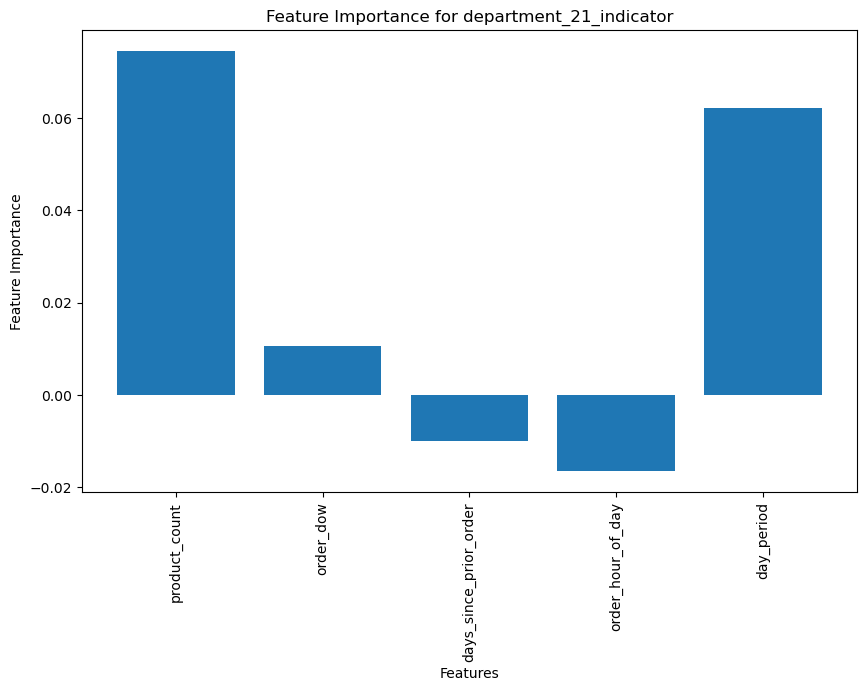

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (5,).

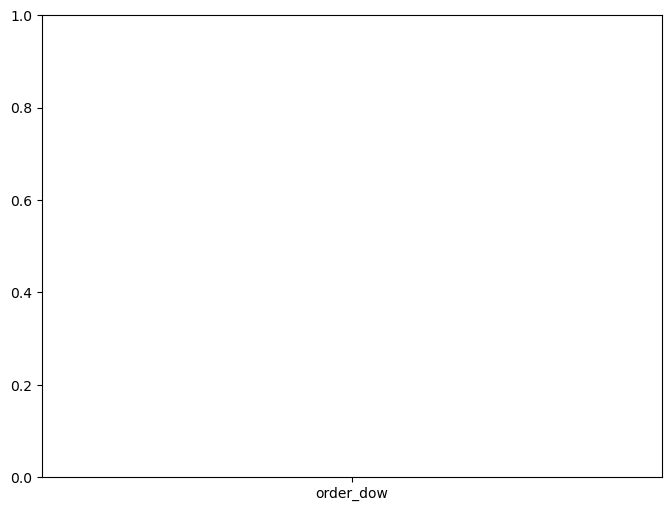

In [26]:


# Get feature importances (coefficients)
feature_importance = model.coef_[0]

plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importance)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title(f'Feature Importance for {department_col_name}')
plt.show()

# Create a bar chart to visualize the feature importances for the selected features
plt.figure(figsize=(8, 6))
plt.bar(features, feature_importance)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Selected Features')
plt.show()

C:\Users\adnan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


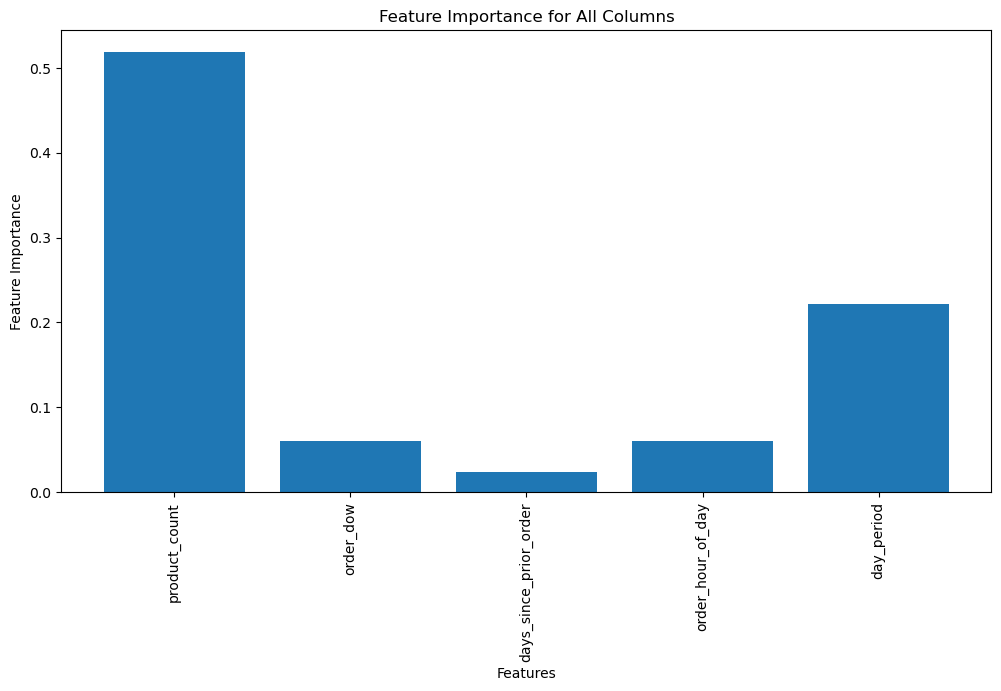

In [25]:
# Combine all the data for training the logistic regression model
X_train_all = train_data.drop(columns=['order_id'] + department_indicator_cols)
y_train_all = train_data[department_indicator_cols]

# Convert y_train_all to a 1D array containing the index of the department with value 1
y_train_all_1d = np.argmax(y_train_all.values, axis=1)

# Logistic Regression Model
model_all = LogisticRegression()

# Train the model
model_all.fit(X_train_all, y_train_all_1d)

# Get feature importances (coefficients) from the trained model
feature_importances_all = model_all.coef_[0]

# Create a bar chart to visualize the feature importances for all columns
plt.figure(figsize=(12, 6))
plt.bar(X_train_all.columns, feature_importances_all)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for All Columns')
plt.show()

In [ ]:
# Plotting the feature importances as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance_df['Importance'], align='center', color='lightgreen')
plt.xticks(range(len(feature_importance)), feature_importance_df['Feature'], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance - Logistic Regression')
plt.show()

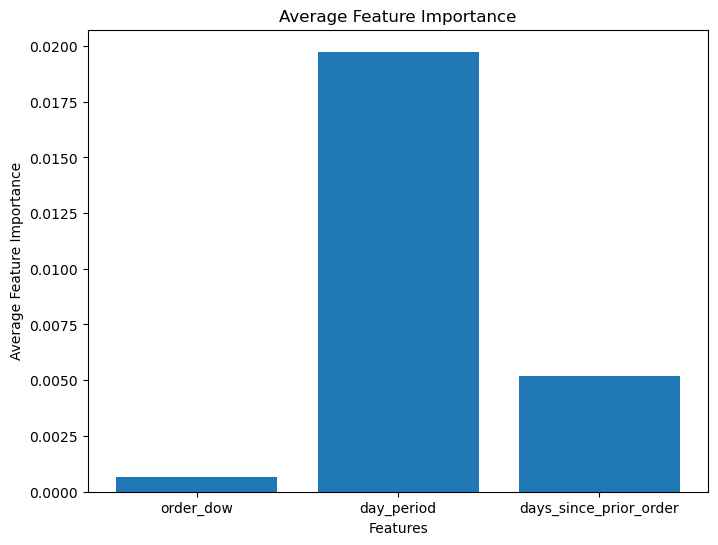

In [30]:
# Define the list of selected features for the model
selected_features = ['order_dow', 'day_period', 'days_since_prior_order']

# Loop through each department indicator column
feature_importance_list = []

for department_col_name in department_indicator_cols:
    X_train = train_data[selected_features]  # Use only the selected features
    y_train = train_data[department_col_name]
    
    X_test = test_data[selected_features]    # Use only the selected features
    y_test = test_data[department_col_name]
    
    # Logistic Regression Model
    model = LogisticRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get the feature importances
    feature_importances = model.coef_[0]
    
    # Append the feature importances for the current department to the list
    feature_importance_list.append(feature_importances)

# Convert the list to a numpy array
feature_importance_array = np.array(feature_importance_list)

# Calculate the average feature importance across all departments
average_feature_importance = np.mean(feature_importance_array, axis=0)

# Create a bar chart to visualize the average feature importances
plt.figure(figsize=(8, 6))
plt.bar(selected_features, average_feature_importance)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance')
plt.show()


C:\Users\adnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\adnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


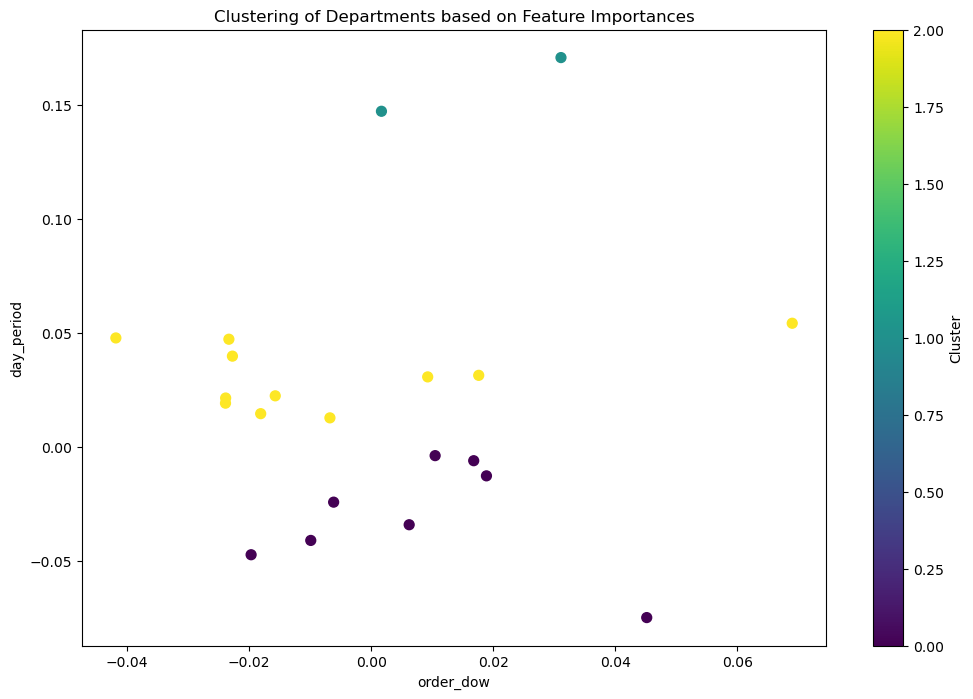

In [32]:
from sklearn.cluster import KMeans

# Loop through each department indicator column
feature_importance_list = []

for department_col_name in department_indicator_cols:
    X_train = train_data[selected_features]  # Use only the selected features
    y_train = train_data[department_col_name]
    
    X_test = test_data[selected_features]    # Use only the selected features
    y_test = test_data[department_col_name]
    
    # Logistic Regression Model
    model = LogisticRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get the feature importances
    feature_importances = model.coef_[0]
    
    # Append the feature importances for the current department to the list
    feature_importance_list.append(feature_importances)

# Convert the list to a numpy array
feature_importance_array = np.array(feature_importance_list)

# Use KMeans clustering to identify groups of departments with similar feature importance patterns
num_clusters = 3  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
department_clusters = kmeans.fit_predict(feature_importance_array)

# Plot the departments and their clusters
plt.figure(figsize=(12, 8))
plt.scatter(feature_importance_array[:, 0], feature_importance_array[:, 1], c=department_clusters, cmap='viridis', s=50)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Clustering of Departments based on Feature Importances')
plt.colorbar(label='Cluster')
plt.show()

C:\Users\adnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\adnan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


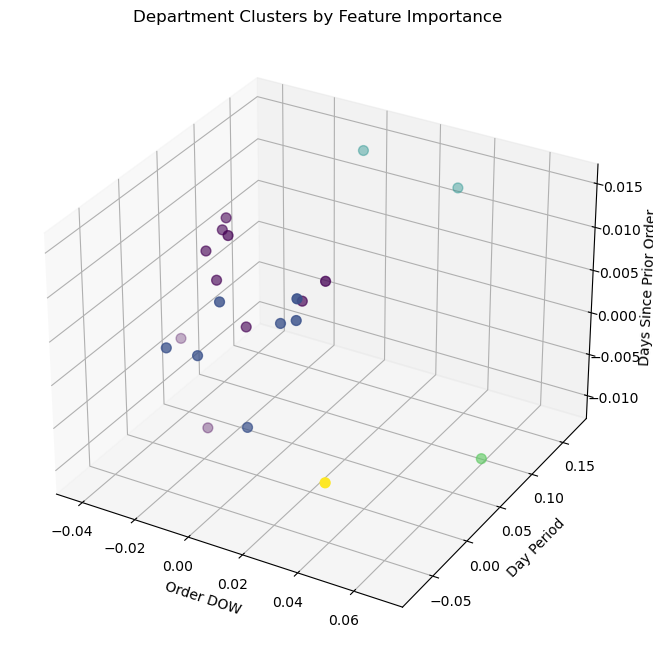

In [37]:
from mpl_toolkits.mplot3d import Axes3D

# Loop through each department indicator column
feature_importance_list = []

for department_col_name in department_indicator_cols:
    X_train = train_data[selected_features]  # Use only the selected features
    y_train = train_data[department_col_name]
    
    X_test = test_data[selected_features]    # Use only the selected features
    y_test = test_data[department_col_name]
    
    # Logistic Regression Model
    model = LogisticRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get the feature importances
    feature_importances = model.coef_[0]
    
    # Append the feature importances for the current department to the list
    feature_importance_list.append(feature_importances)

# Convert the list to a numpy array
feature_importance_array = np.array(feature_importance_list)

# Use KMeans clustering to identify groups of departments with similar feature importance patterns
num_clusters = 5  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
department_clusters = kmeans.fit_predict(feature_importance_array)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the departments and their clusters
ax.scatter(feature_importance_array[:, 0], feature_importance_array[:, 1], feature_importance_array[:, 2],
           c=department_clusters, cmap='viridis', s=50)

# Set axis labels
ax.set_xlabel('Order DOW')
ax.set_ylabel('Day Period')
ax.set_zlabel('Days Since Prior Order')


# Set plot title
plt.title('Department Clusters by Feature Importance')

plt.show()

In [17]:
classification_reports

{'department_1_indicator': {'False': {'precision': 0.6973898966308834,
   'recall': 0.8646354303764149,
   'f1-score': 0.7720592015865437,
   'support': 60784},
  'True': {'precision': 0.6601825465658944,
   'recall': 0.41209074503738075,
   'f1-score': 0.5074361538339444,
   'support': 38790},
  'accuracy': 0.6883423383614197,
  'macro avg': {'precision': 0.6787862215983889,
   'recall': 0.6383630877068978,
   'f1-score': 0.639747677710244,
   'support': 99574},
  'weighted avg': {'precision': 0.6828954190662487,
   'recall': 0.6883423383614197,
   'f1-score': 0.6689727731782912,
   'support': 99574}},
 'department_2_indicator': {'False': {'precision': 0.986864040813867,
   'recall': 1.0,
   'f1-score': 0.9933885968459361,
   'support': 98266},
  'True': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1308},
  'accuracy': 0.986864040813867,
  'macro avg': {'precision': 0.9934320204069336,
   'recall': 0.5,
   'f1-score': 0.49669429842296803,
   'support': 99574},
  'weig

In [26]:
'''
# Flatten the classification_reports dictionary
flattened_classification_reports = {}
for department, metrics in classification_reports.items():
    if isinstance(metrics, dict):
        for class_label, class_metrics in metrics.items():
            if isinstance(class_metrics, dict):
                for metric, value in class_metrics.items():
                    key = f"{department}_{class_label}_{metric}"
                    flattened_classification_reports[key] = value
# Convert the flattened dictionary to a DataFrame
df_classification_reports = pd.DataFrame(flattened_classification_reports, index=[0])

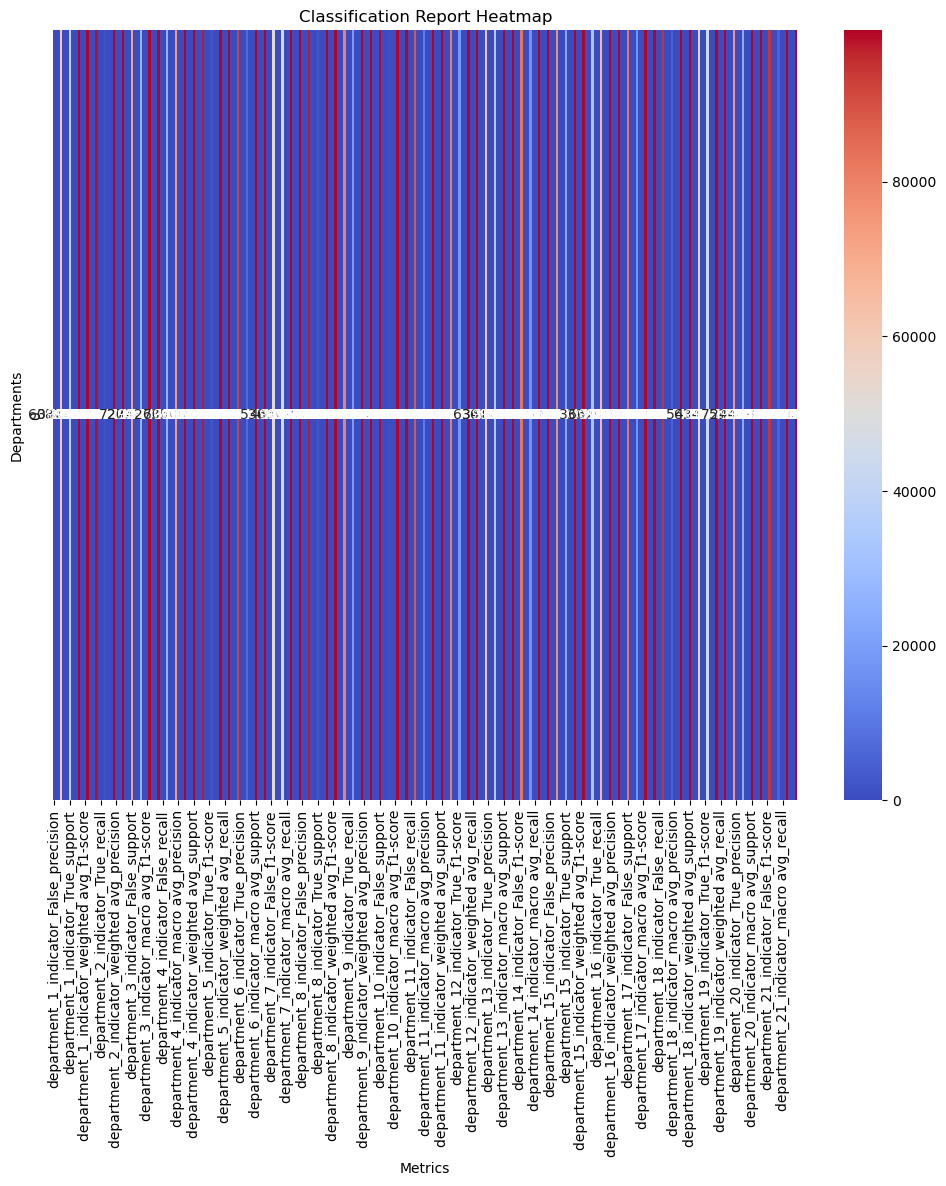

In [28]:
#Useless Heatmap
'''


plt.figure(figsize=(12, 10))
sns.heatmap(df_classification_reports, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Departments')
plt.show()

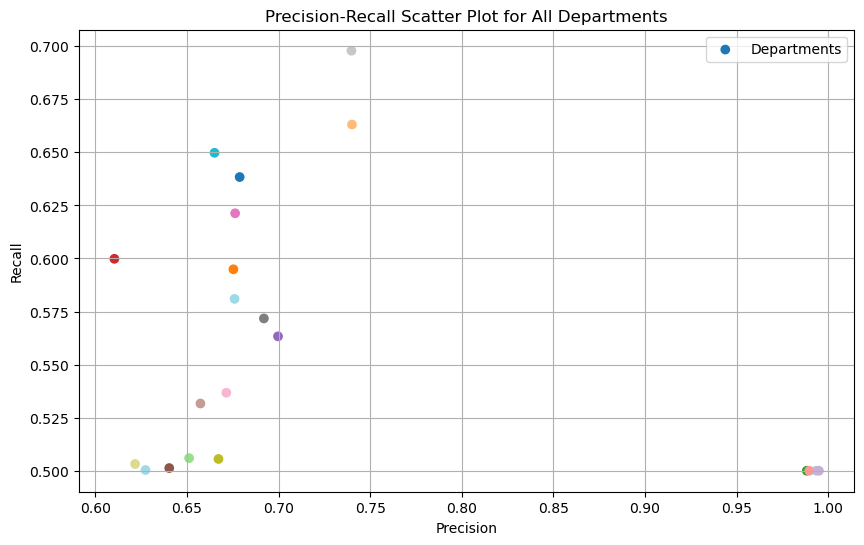

In [29]:


# Extract precision and recall values for each department
departments = list(classification_reports.keys())
precision_values = [classification_reports[dept]['macro avg']['precision'] for dept in departments]
recall_values = [classification_reports[dept]['macro avg']['recall'] for dept in departments]


cmap = plt.get_cmap('tab20')  
colors = cmap(np.linspace(0, 1, len(departments)))

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(precision_values, recall_values, marker='o', color=colors, label='Departments')


plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Scatter Plot for All Departments')
plt.grid(True)


plt.legend()


plt.show()

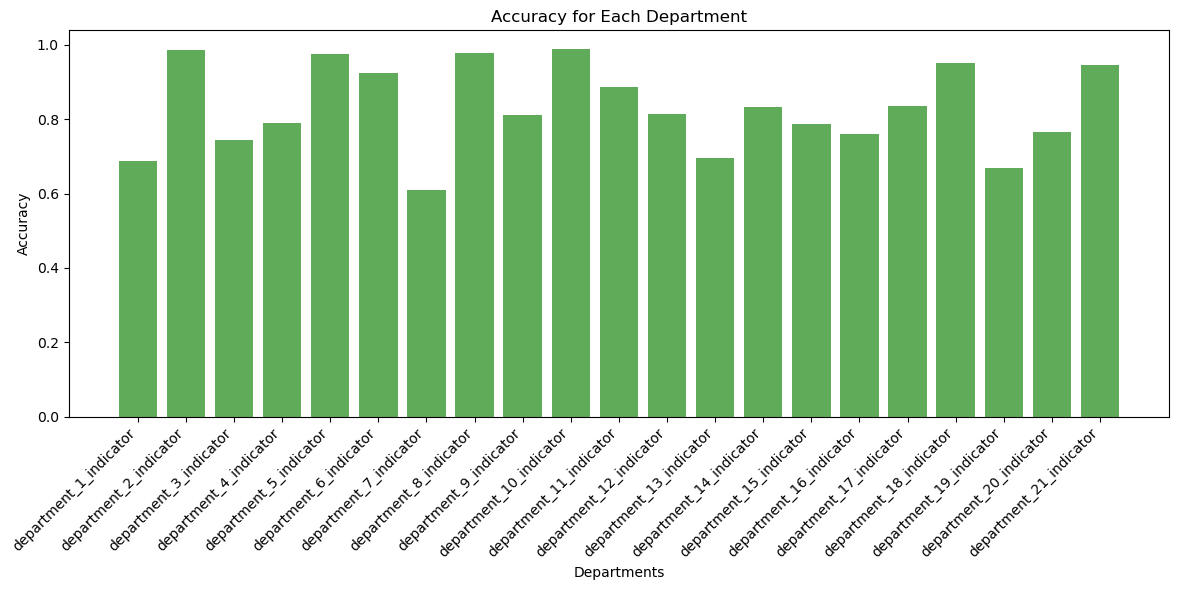

In [38]:
import matplotlib.pyplot as plt

# Assuming you already have the classification_reports dictionary
# The keys of the dictionary are the department names, and the values are dictionaries containing 'accuracy'
# classification_reports = {...}

# Extract department names and accuracy values
departments = list(classification_reports.keys())
accuracies = [classification_reports[dept]['accuracy'] for dept in departments]

# Create a bar plot for each department
plt.figure(figsize=(12, 6))
plt.bar(departments, accuracies, color='#60ab59')

# Set labels and title
plt.xlabel('Departments')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Department')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

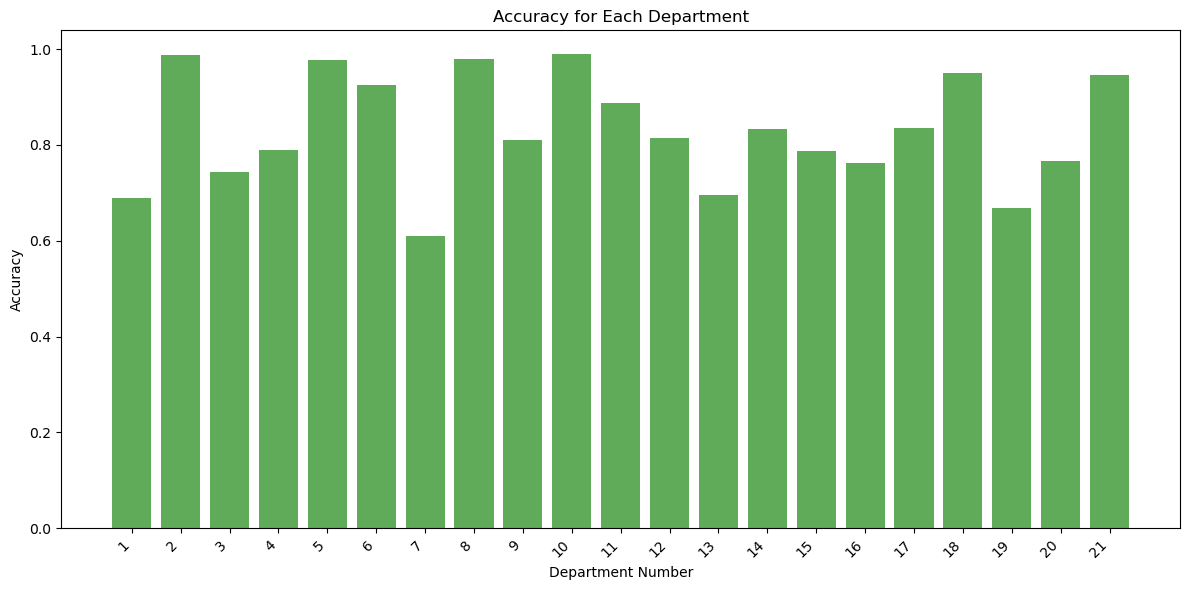

In [39]:

departments = list(classification_reports.keys())
accuracies = [classification_reports[dept]['accuracy'] for dept in departments]


instacart_green = '#60ab59'


plt.figure(figsize=(12, 6))
plt.bar(range(len(departments)), accuracies, color=instacart_green)


plt.xlabel('Department Number')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Department')


plt.xticks(range(len(departments)), range(1, len(departments) + 1), rotation=45, ha='right')


plt.tight_layout()
plt.show()


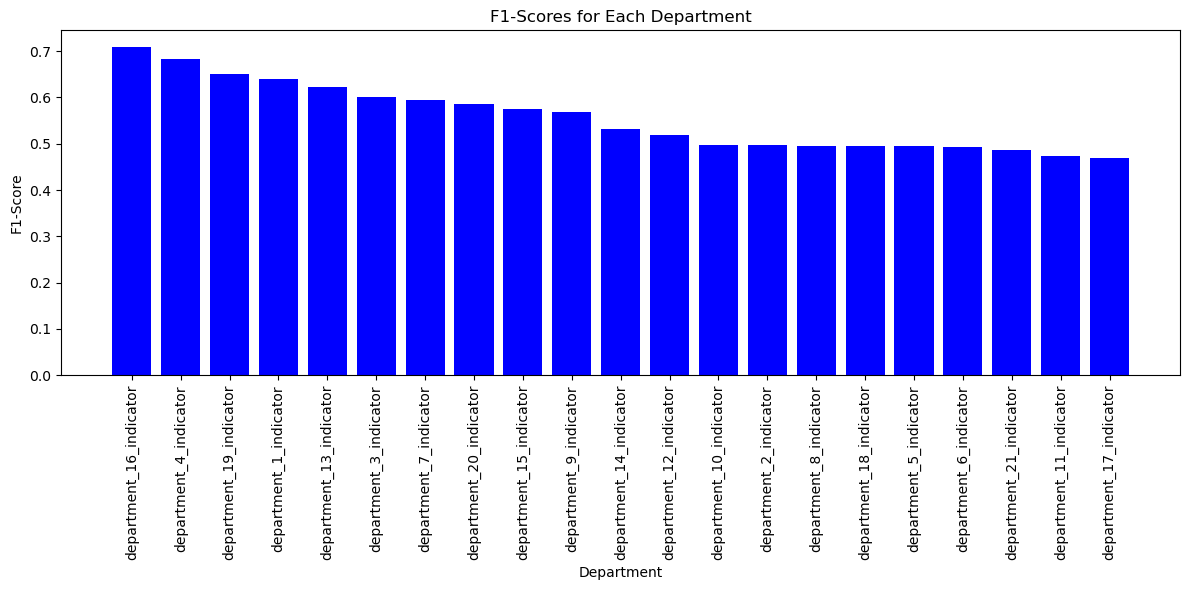

In [31]:

f1_scores = {}


for department, metrics in classification_reports.items():
    f1_scores[department] = metrics['macro avg']['f1-score']


df_f1_scores = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['F1-Score'])


df_f1_scores = df_f1_scores.sort_values(by='F1-Score', ascending=False)


plt.figure(figsize=(12, 6))
plt.bar(df_f1_scores.index, df_f1_scores['F1-Score'], color='blue')
plt.xlabel('Department')
plt.ylabel('F1-Score')
plt.title('F1-Scores for Each Department')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [33]:

custom_data = pd.DataFrame({
    'order_dow': [2],  # Day of week (e.g., Wednesday)
    'day_period': ['2'],  # Time period (e.g., Afternoon)
    'order_hour_of_day': ['5'],
    'product_count': ['2'],
    'days_since_prior_order': [7]  # Days since the last order (e.g., 7 days)
})

# Make predictions 
probabilities = model.predict_proba(custom_data)

# Get the probabilities for each department
departments = model.classes_  # Get the department names
department_probabilities = dict(zip(departments, probabilities[0]))

# Print the department probabilities
for department, probability in department_probabilities.items():
    print(f"Department: {department}, Probability: {probability}")

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [103]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [104]:

y_pred = model.predict(X_test)


In [106]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")



print(classification_report(y_test, y_pred,zero_division=1))

Accuracy: 0.74
              precision    recall  f1-score   support

       False       1.00      0.00      0.00     26068
        True       0.74      1.00      0.85     73506

    accuracy                           0.74     99574
   macro avg       0.87      0.50      0.42     99574
weighted avg       0.81      0.74      0.63     99574

